<a href="https://colab.research.google.com/github/sysiphe0/kaggle/blob/main/kaggle_creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from google.colab import drive

In [3]:
def chk_dup_features(df):
  remove = []
  c = df.columns
  for i in range(len(c)-1):
    v = df[c[i]].values
    for j in range(i+1, len(c)):
      if np.array_equal(v, df[c[j]].values):
        remove.append(c[j])
  return list(set(remove))

In [4]:
def chk_constant_features(df):
  remove = []
  c = df.columns
  for i in range(len(c)-1):
    if df[c[i]].std() == 0:
      remove.append(c[i])
  return remove

In [5]:
def chk_correlation(df, threshold):
  col_corr = set()
  corr_matrix = df.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
card_df = pd.read_csv("/content/drive/My Drive/creditcard.csv")

In [8]:
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [9]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score

In [11]:
def get_preprocessed_df_old(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [16]:
def get_preprocessed_df_old2(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [12]:
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:,-1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [18]:
print(y_train.value_counts()/y_train.shape[0]*100)
print(y_test.value_counts()/y_test.shape[0]*100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [19]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_score = roc_auc_score(y_test, pred)
  print('confusion matrix')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, roc: {4:.4f}'.format(accuracy, precision, recall, f1, roc_score))

In [20]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test, lr_pred)

confusion matrix
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, roc: 0.8006


In [21]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  get_clf_eval(tgt_test, pred)

In [22]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

confusion matrix
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, roc: 0.8817


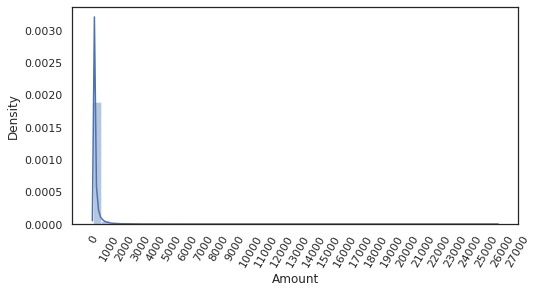

In [23]:
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df_standard(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [24]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

confusion matrix
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, roc: 0.8006
confusion matrix
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, roc: 0.8817


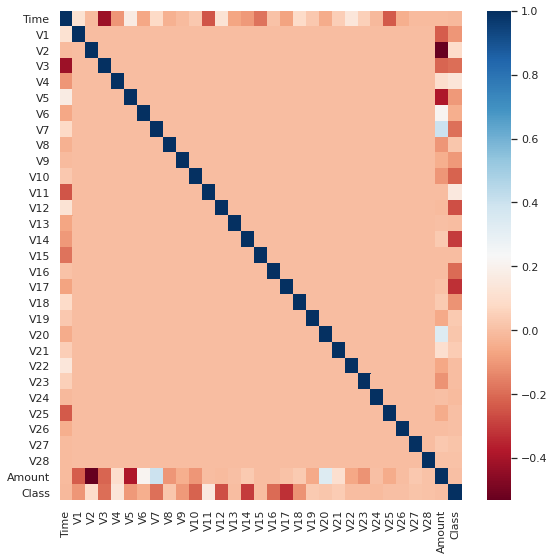

In [25]:
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [46]:
def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [69]:
outlier_index = get_outlier(df = card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [53]:
outlier_index = get_outlier(df = card_df, column='V17', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([], dtype='int64')


In [70]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  #이상치 데이터 삭제
  oulier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

In [71]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [72]:
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

confusion matrix
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, roc: 0.8355
confusion matrix
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, roc: 0.9144


### SMOTE (over sampling)

In [73]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


In [74]:
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

confusion matrix
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, roc: 0.9485


In [77]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

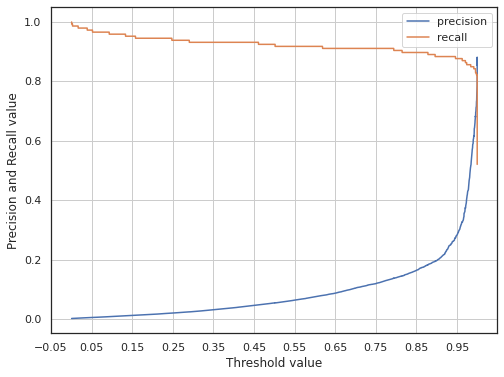

In [78]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [80]:
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

confusion matrix
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, roc: 0.9246
